In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
folder_path = '/content/drive/MyDrive/Segmented Medicinal Leaf Images'


In [ ]:
!pip install scikit-image


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Feature Extraction


def extract_features(folder_path, image_size=(64,64)):
    features = []
    labels = []

    for label in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, label)
        if not os.path.isdir(class_folder):
            continue

        for file in tqdm(os.listdir(class_folder), desc=f"Processing {label}"):
            file_path = os.path.join(class_folder, file)
            img = cv2.imread(file_path)
            if img is None:
                continue

            # Resizing image
            img = cv2.resize(img, image_size)

            # Feature 1: Color histogram (for each channel)
            chans = cv2.split(img)
            hist_features = []
            for chan in chans:
                hist = cv2.calcHist([chan], [0], None, [16], [0, 256])  # 16 bins histogram per channel
                hist = cv2.normalize(hist, hist).flatten()
                hist_features.extend(hist)

            # Feature 2: Texture (grayscale pixel intensities flattened)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            gray_features = gray.flatten() / 255.0  # normalize

            # Combine features
            combined_features = np.hstack([hist_features, gray_features])
            features.append(combined_features)
            labels.append(label)

    return np.array(features), np.array(labels)


In [ ]:
# 2. Loading the data and extracting features

folder_path = '/content/drive/MyDrive/Segmented Medicinal Leaf Images'
X, y = extract_features(folder_path)


# Encoding labels to numbers
le = LabelEncoder()
y_encoded = le.fit_transform(y)


Processing Punica Granatum (Pomegranate): 100%|██████████| 79/79 [00:02<00:00, 37.98it/s]
Processing Tabernaemontana Divaricata (Crape Jasmine): 100%|██████████| 56/56 [00:01<00:00, 51.33it/s]
Processing Syzygium Jambos (Rose Apple): 100%|██████████| 56/56 [00:01<00:00, 51.64it/s]
Processing Muntingia Calabura (Jamaica Cherry-Gasagase): 100%|██████████| 56/56 [00:01<00:00, 38.15it/s]
Processing Nyctanthes Arbor-tristis (Parijata): 100%|██████████| 40/40 [00:00<00:00, 50.04it/s]
Processing Plectranthus Amboinicus (Mexican Mint): 100%|██████████| 48/48 [00:01<00:00, 47.24it/s]
Processing Psidium Guajava (Guava): 100%|██████████| 65/65 [00:01<00:00, 35.22it/s]


In [ ]:
# 3. Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [ ]:
# 4. Training a Random Forest Model
print("Training Random Forest classifier...")
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

Training Random Forest classifier...


RandomForestClassifier(random_state=42)

In [ ]:
# 5. Evaluating
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc*100:.2f}%")

Test Accuracy: 83.11%


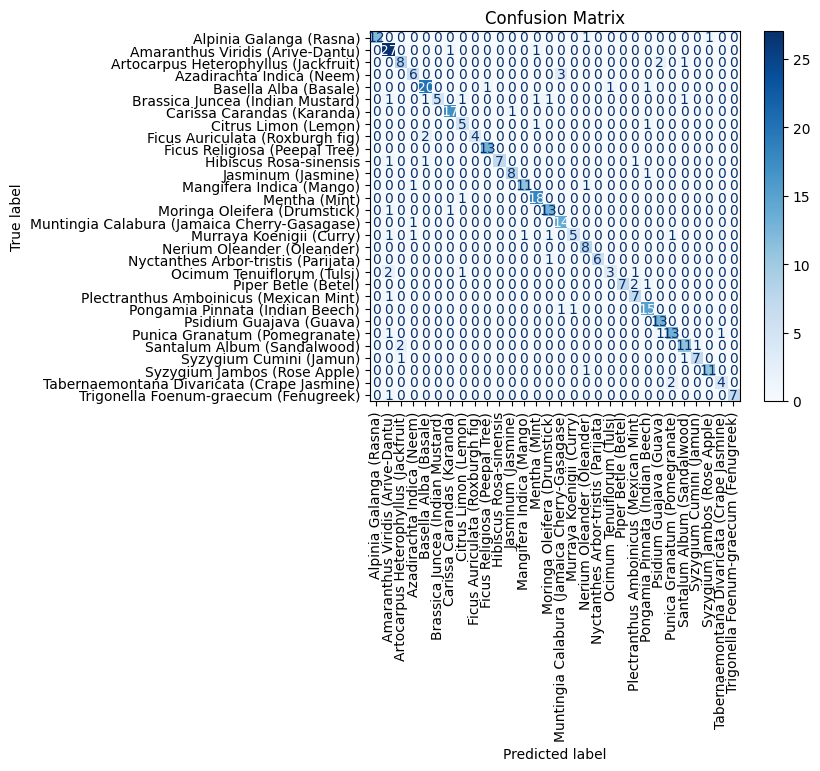

In [ ]:
# 6. Plotting a confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=90, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from google.colab import files

# Predicting with a new image
def predict_leaf_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print("Could not read image")
        return None
    img = cv2.resize(img, (64,64))

    # Extract same features as before
    chans = cv2.split(img)
    hist_features = []
    for chan in chans:
        hist = cv2.calcHist([chan], [0], None, [16], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        hist_features.extend(hist)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_features = gray.flatten() / 255.0
    combined_features = np.hstack([hist_features, gray_features]).reshape(1, -1)

    prediction = model.predict(combined_features)
    return le.inverse_transform(prediction)[0]


uploaded = files.upload()


uploaded_filename = next(iter(uploaded))


predicted_label = predict_leaf_image(uploaded_filename)
print("Predicted herb:", predicted_label)


Saving CL-S-001.jpg to CL-S-001 (1).jpg
Predicted herb: Citrus Limon (Lemon)
